In [63]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
# from impedance.models.circuits import CustomCircuit
from matplotlib.ticker import MultipleLocator
from scipy.optimize import minimize
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from models import *

## Define the arbitary tortuosity model

In [64]:
@element(num_params=4,units=["","","","",""],overwrite=True)
def arbitRCPE(p,f):
    Q, alpha, a, b = p[0], p[1], p[2], p[3]
    
    def R(x):
        # return a/(1+b*x)
        return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*R(x),y[3]*R(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
 
    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1
    return Z_list


## Plot that profile here

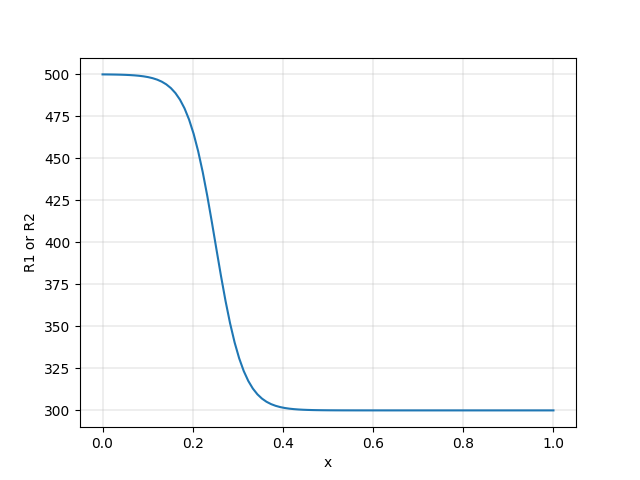

In [65]:
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
axx.plot(x,R(x))
axx.set_xlabel("x")
axx.set_ylabel("R1 or R2")
axx.grid(linewidth=0.3)
fig1.savefig("prof1.png",dpi=400)
# axx2=axx.twinx()
# axx2.set_ylabel("R1")

# axx.plot([0,0.2063,0.2063,1],[873,873,387,387])

## Find Out the dip angle and the apparent R_ion

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:144: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


6.312229192302251-1735.856189540985
intercept: 274.9989166517999
R_ion_app: 412.4983749776999


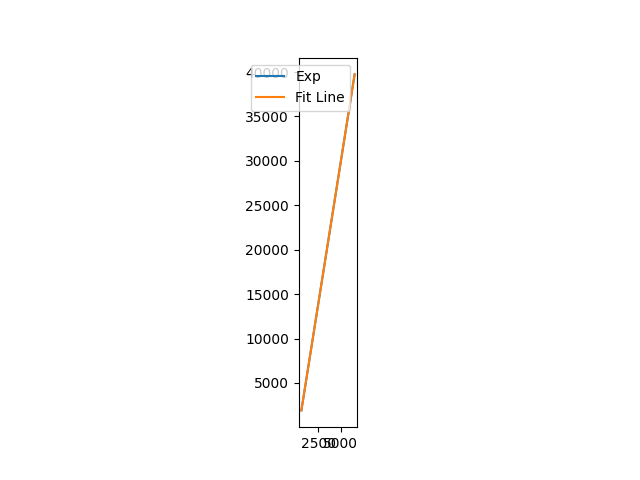

In [66]:
Q=6e-4
alpha=0.9
a=4
b=4
param=[Q,alpha,a,b]
freq_range=np.logspace(-2,3,100)
c=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
z=c.predict(frequencies=freq_range)
#found the dip angle
dip_angle=alpha*45-np.min(-np.angle(z,deg=True))

#found the Rion by finding the intercept

datax=np.real(z[:int(len(z)*0.3)])
datay=np.imag(z[:int(len(z)*0.3)])

ff,ax=plt.subplots()

ax.plot(datax,-datay,label="Exp")
ax.set_aspect("equal")

#actual fitting of a straight line
cp=np.polyfit(datax,-datay,1)
cp[0] 
cp[1] 
print(f"{cp[0]}{cp[1]}")

def y(x,cp):
    return cp[0]*x+cp[1]

ax.plot(datax,y(datax,cp),label="Fit Line")
R_ion_app=(3/2)*(-cp[1]/cp[0])

print(f"intercept: {-cp[1]/cp[0]}")
print(f"R_ion_app: {R_ion_app}")

ax.legend()

In [67]:
import json
file_path = "theta_data_all.json"

with open(file_path, "r") as file:
    json_data = file.read()

theta_list=json.loads(json_data)

In [68]:
def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#the ratio range for which the theta data is generated
ratio_range=np.linspace(1.2,10,50)

for pf,idx in zip(["Two-step","Linear","Inverse Linear"],[0,1,2]):
    if(pf=="Two-step"):
        # theta_dip_two=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R1_by_R2_two=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R2_two=2*R_ion_app/(1+R1_by_R2_two)
        R1_two=R2_two*R1_by_R2_two
    elif(pf=="Linear"):
        R1_by_R2_lin=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R2_lin=4*R_ion_app/(1+3*R1_by_R2_lin)
        R1_lin=R2_lin*R1_by_R2_lin
    else:
        R1_by_R2_ilin=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        # R2_ilin=4*R_ion_app*(R1_by_R2_ilin**3-3*R1_by_R2_ilin**2+3*R1_by_R2_ilin-1)/(9*R1_by_R2_ilin*(2*np.log(R1_by_R2_ilin)*R1_by_R2_ilin**2-3*R1_by_R2_ilin**2+4*R1_by_R2_ilin-1))
        # R1_ilin=R2_ilin*R1_by_R2_ilin

        R2_ilin=2*R_ion_app*(R1_by_R2_ilin**3-3*R1_by_R2_ilin**2+3*R1_by_R2_ilin-1)/(3*R1_by_R2_ilin*(2*np.log(R1_by_R2_ilin)*R1_by_R2_ilin**2-3*R1_by_R2_ilin**2+4*R1_by_R2_ilin-1))
        R1_ilin=R2_ilin*R1_by_R2_ilin

R1_by_R2_two
# R1_by_R2_lin
# R2_lin
R1_ilin
# R2_ilin

# theta_dip_ll=[]

541.43145373158

## Show the point of dip angle for lin and ilin and two on the plots

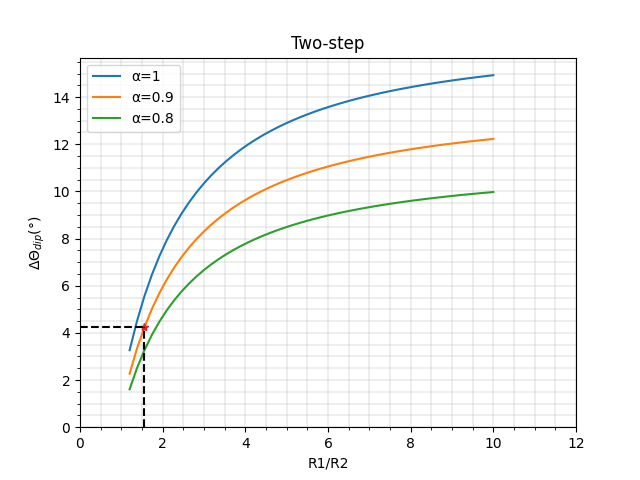

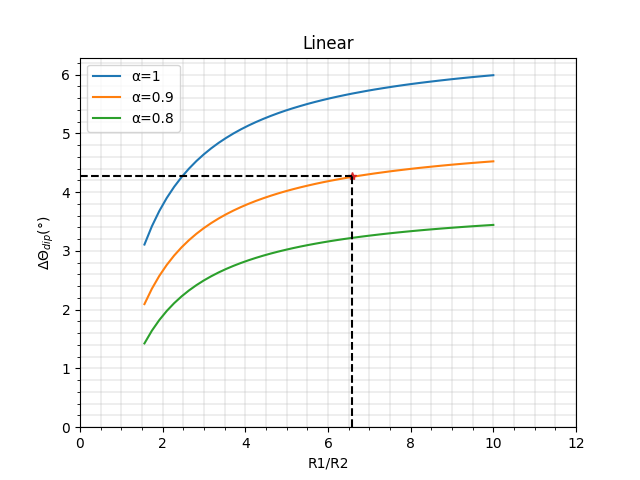

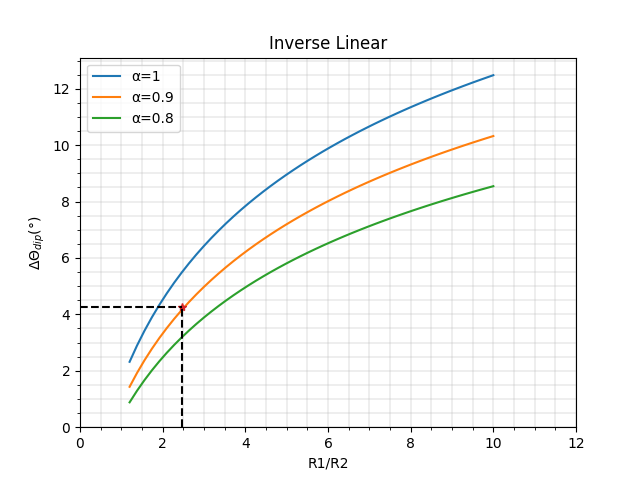

In [69]:
fig,axtwo=plt.subplots()
fig1,axlin=plt.subplots()
fig2,axilin=plt.subplots()
x=ratio_range

crap_till_lin=2

for idx1,ax,fg,title in zip([0,1,2],(axtwo,axlin,axilin),(fig,fig1,fig2),("Two-step","Linear","Inverse Linear")):
    for idx2,a in zip([0,1,2],[1,0.9,0.8]):
        if(idx1==1):
            ax.plot(ratio_range[crap_till_lin:],theta_list[idx1][idx2][crap_till_lin:],label=f"α={a}")
            
        else:
            ax.plot(ratio_range,theta_list[idx1][idx2],label=f"α={a}")
            # ax.plot(ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)],dip_angle,"*")
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.legend()
        ax.grid(which="both",linewidth=0.3)
        ax.minorticks_on()
        ax.set_xlabel("R1/R2")
        ax.set_ylabel("$\Delta \Theta_{dip} (\degree)$")
        ax.set_title(title)
    ax.plot(ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)],dip_angle,"*")
    ax.plot([ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)],ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)]],[0,dip_angle],"--",color="black")
    ax.plot([0,ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)]],[dip_angle,dip_angle],"--",color="black")
    ax.set_xlim(0,12)
    # ax.set_ymargin(1)
    ax.set_ylim(0)
    fg.savefig(f"prof1_{title}.png",dpi=300)

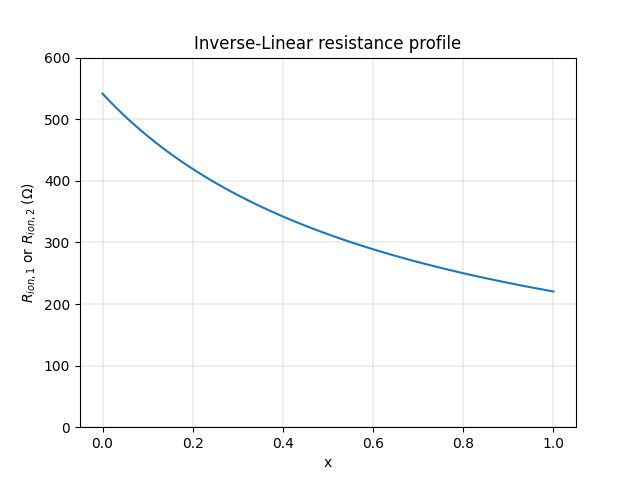

In [109]:
delta=0.2063
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
#plot the arbitray profile
# axx.plot(x,R(x),label="Arbitrary")
#plot the fitted profiles
# axx.plot([0,delta,delta,1],[R1_two,R1_two,R2_two,R2_two],label="Two-step")
# axx.set_title("Two-step resistance profile")
axx.set_title("Inverse-Linear resistance profile")
# axx.set_title("Linear resistance profile")
# axx.plot([0,1],[R1_lin,R2_lin],label="Linear")

def R_ilin(x):
    return 1/(1/R1_ilin+(1/R2_ilin-1/R1_ilin)*x)
axx.plot(x,R_ilin(x),label="Inv Lin")

# axx.set_xlim(0,)
axx.set_ylim(0,600)

axx.set_xlabel("x")
axx.set_ylabel("$R_{ion,1}$ or $R_{ion,2}\;$($\Omega$)")
# axx.legend()
axx.grid(linewidth=0.3)
# fig1.savefig("fitted_prof1.png",dpi=400)
# fig1.savefig("two-step.png",dpi=500)
# fig1.savefig("Linear.png",dpi=500)
fig1.savefig("Inverse-Linear.png",dpi=500)

## Show the fitted profiles ( two, lin and ilin)

In [71]:
Q=6e-4
alpha=0.9
delta=0.2063
a=4
b=4
param=[Q,alpha,a,b]
c_arbi=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
# c=CustomCircuit(initial_guess=[6e-4,0.9,4,4],circuit="arbitRCPE")
z_arbi=c_arbi.predict(frequencies=np.logspace(-2,3,100))

c_two=CustomCircuit(initial_guess=[R1_two,R1_two*Q,R2_two*Q,delta,alpha],circuit="TLMtwo")
z_two=c_two.predict(frequencies=freq_range)

c_lin=CustomCircuit(initial_guess=[R1_lin,R1_lin*Q,R2_lin*Q,alpha],circuit="TLMlinnew")
z_lin=c_lin.predict(frequencies=freq_range)

print(R1_ilin)
c_ilin=CustomCircuit(initial_guess=[R1_ilin,R1_ilin*Q,R2_ilin*Q,alpha],circuit="TLMilinnew")
mp.dps=100
z_ilin=c_ilin.predict(frequencies=freq_range)
mp.dps=30
# c_ilin=CustomCircuit(initial_guess=[R1_ilin,R1_ilin*Q,R2_ilin*Q,alpha],circuit="TLMilinnew")
# z_ilin=c_ilin.predict(frequencies=np.logspace(-2,3,100))



# print(0.9*45-np.min(-np.angle(z,deg=True)))

541.43145373158


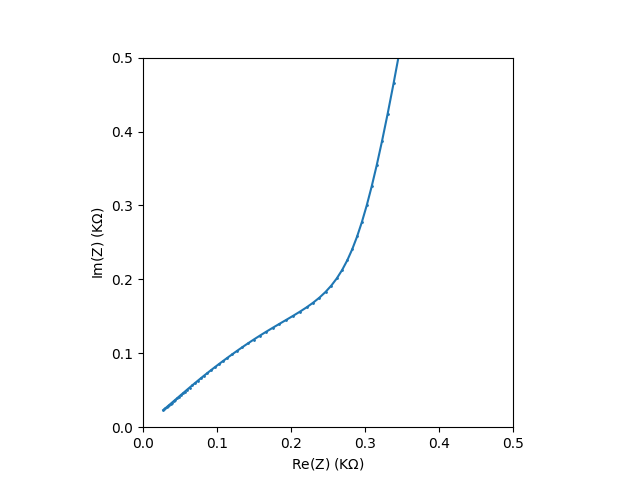

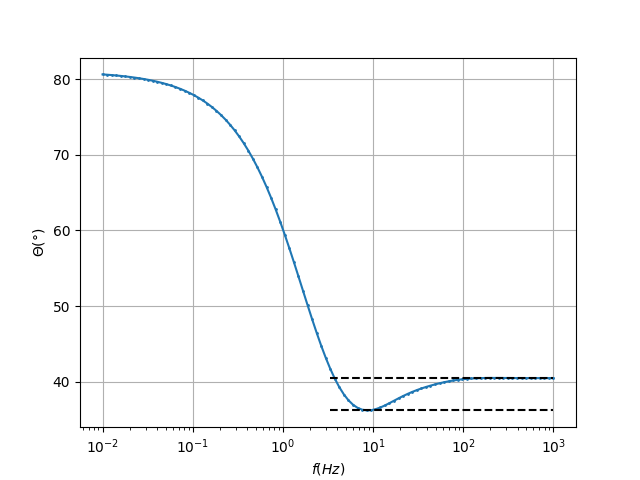

In [94]:
fig, ax=plt.subplots()
ax.plot(np.real(z_arbi)/1000,-np.imag(z_arbi)/1000,label="Arbitrary",marker=".",ms=2)
# ax.plot([0,0],[0.35,0.35])
# ax.plot(np.real(z_two)/1000,-np.imag(z_two)/1000,label="Two-step",marker=".",ms=2)
# ax.plot(np.real(z_lin)/1000,-np.imag(z_lin)/1000,label="Linear",marker=".",ms=2)
# ax.plot(np.real(z_ilin)/1000,-np.imag(z_ilin)/1000,label="Inverse Linear",marker=".",ms=2)
# ax.plot(np.real(z_lin)/1000,-np.imag(z_lin)/1000)
ax.set_aspect("equal")
ax.set_xlabel("Re(Z)$\;($K$\Omega$)")
ax.set_ylabel("Im(Z)$\;($K$\Omega$)")
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
# ax.legend()
# fig.savefig("nyq_prof1.png",dpi=400)
fig.savefig("nyqfull_demo.png",dpi=500)
# ax.legend()
# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax.grid(True)

fig2, ax2=plt.subplots()
ax2.plot(freq_range,-np.angle(z_arbi,deg=True),marker=".",label="Arbitrary",ms=2)

ax2.plot(freq_range[int(len(freq_range)/2):len(freq_range)],np.full(int(len(freq_range)/2),-np.angle(z_arbi[len(z_arbi)-1],deg=True)),linestyle="--",color="black",label="Arbitrary")

# np.full(int(len(freq_range)/2),np.full(len(freq_range)-np.min(-np.angle(z,deg=True))))

ax2.plot(freq_range[int(len(freq_range)/2):len(freq_range)],np.full(int(len(freq_range)/2),np.min(-np.angle(z,deg=True))),linestyle="--",color="black",label="Arbitrary")

# ax2.plot(np.logspace(-2,3,100),-np.angle(z_two,deg=True),marker=".",label="Two-step",ms=2)
# ax2.plot(np.logspace(-2,3,100),-np.angle(z_lin,deg=True),marker=".",label="Linear",ms=2)
# ax2.plot(np.logspace(-2,3,100),-np.angle(z_ilin,deg=True),marker=".",label="Inverse Linear",ms=2)
# ax2.legend()
# axx.yaxis.set_minor_locator(MultipleLocator(0.5))
ax2.set_ylabel("$\Theta (\degree)$")
ax2.set_xlabel("$f (Hz)$")
ax2.set_xscale("log")
# ax2.set_ylim(32,50)
# fig2.savefig("bode_prof1.png",dpi=400)
fig2.savefig("bode_demo.png",dpi=500)
ax2.grid(True)


In [73]:
# print(dip_angle)
# print(R1_by_R2_two)
# print(R1_by_R2_lin)
# print(R1_by_R2_ilin)

print(R1_ilin)
print(R2_ilin)

print(R_ion_app)

print(dip_angle)

541.43145373158
220.35001023959646
412.4983749776999
4.268797175965155
